In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from PIL import Image
import scipy
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json
import time

In [2]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout)
from tensorflow.keras.layers import  Dropout , BatchNormalization , Dense
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint, CSVLogger
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy as logloss
from tensorflow.keras.metrics import categorical_accuracy

#nvidia gpu only
from tensorflow.keras import mixed_precision

In [3]:
#nvidia gpu only
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9


In [4]:
#nvidia gpu only
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [5]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.applications.convnext import ConvNeXtSmall
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet169


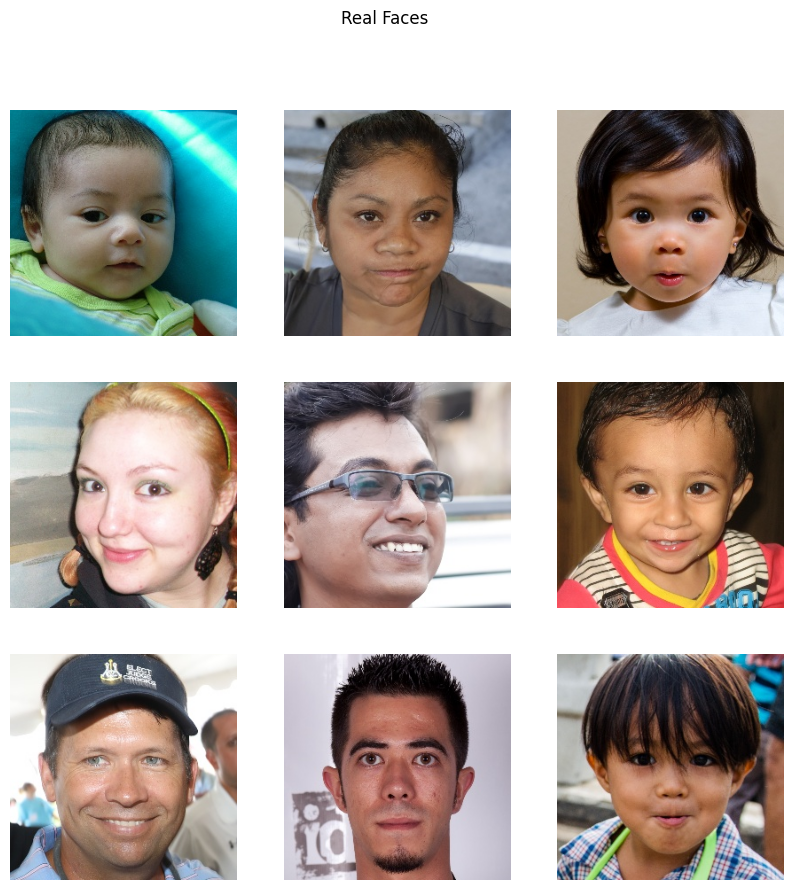

In [27]:
path = 'DeepFake_Photo/real_vs_fake/real-vs-fake'

#/Users/user/Desktop/SP_Jain/Courses/Semester_5/Data Mining/Project/archive/real_vs_fake/real-vs-fake

def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(path, 'Real').show()

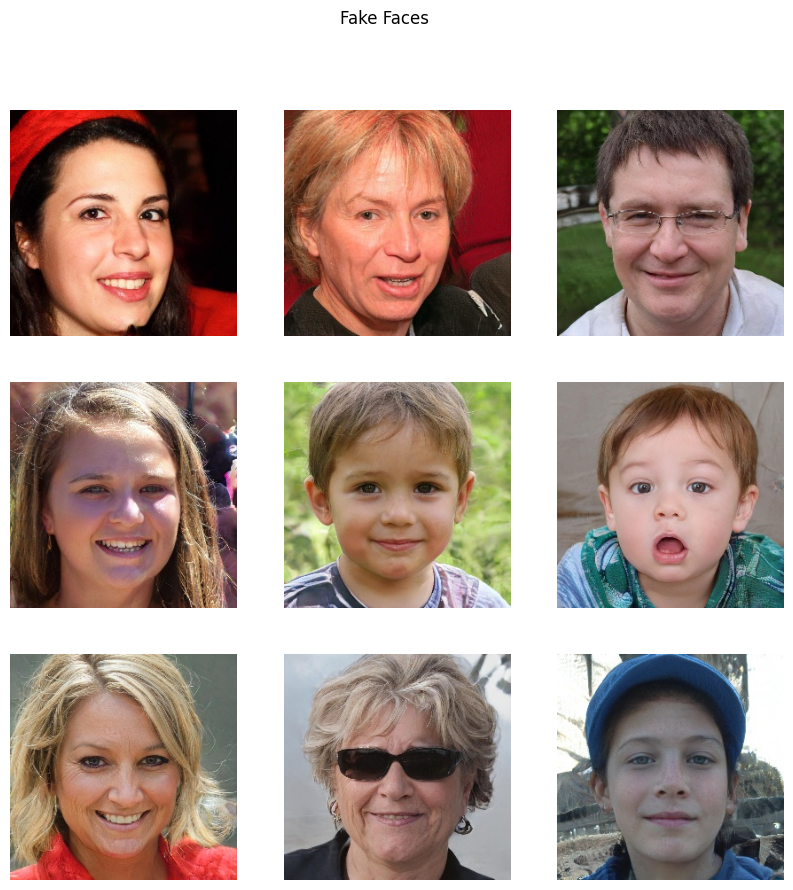

In [26]:
plot_img(path, 'Fake').show()

# Data Preprocessing

In [8]:
#Generating Greyscale Dataset

#batch size
bs = 256

#define dimensions for input layer
row, col = 128, 128
grey_train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
grey_training_set = grey_train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 color_mode='grayscale',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
grey_val_test_datagen = ImageDataGenerator(rescale=1./255)

grey_validation_set = grey_val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      color_mode='grayscale',
                                                      shuffle=False,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
grey_test_set = grey_val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                color_mode='grayscale',
                                                shuffle=False,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
grey_training_set.class_indices

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [9]:
#Generating RGB Dataset

#batch size
bs = 256

#define dimensions for input layer
row, col = 128, 128
RGB_train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
RGB_training_set = RGB_train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
RGB_val_test_datagen = ImageDataGenerator(rescale=1./255)

RGB_validation_set = RGB_val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      shuffle=False,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
RGB_test_set = RGB_val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                shuffle=False,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
RGB_training_set.class_indices

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [10]:
#Training using EfficientNetV2-B3 using Greyscale
D_fake_net = EfficientNetV2B3(weights=None,
                         include_top=False,
                         input_shape=(128,128,1)
                        )
def get_model():
    
    model = tf.keras.models.Sequential([D_fake_net,
                                        GlobalAveragePooling2D(),
                                        #Dense(512, activation='relu'),
                                        #BatchNormalization(),
                                        #Dropout(0.2),
                                        Dense(1, activation='sigmoid', dtype = 'float32')
                                      ])
    #following line for nvidia gpu only
    model.compile(optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.008)), loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.compile(optimizer=Adam(lr=0.008),loss='binary_crossentropy',metrics=['accuracy'])

    return model

Efficient_G_net = get_model()
Efficient_G_net.summary()

checkpoint = ModelCheckpoint(filepath='Efficient_Grey_net.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.00008
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 4, 4, 1536)       12929902  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 12,931,439
Trainable params: 12,822,223
Non-trainable params: 109,216
_________________________________________________________________


In [11]:
# timing the training process
tic1 = time.perf_counter()    # start timer

hist1 = Efficient_G_net.fit(grey_training_set,
                    validation_data=grey_validation_set,
                    callbacks=callbacks,
                    epochs=10
                   )

toc1 = time.perf_counter()    # stop timer
print(f"\n[INFO] Training completed in {(toc1 - tic1)/60:0.4f} minutes\n")

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6968 - accuracy: 0.5523
Epoch 1: val_loss improved from inf to 0.99811, saving model to Efficient_Grey_net.h5
391/391 [==============================] - 95s 201ms/step - loss: 0.6968 - accuracy: 0.5523 - val_loss: 0.9981 - val_accuracy: 0.5000 - lr: 0.0080
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.7560
Epoch 2: val_loss improved from 0.99811 to 0.97290, saving model to Efficient_Grey_net.h5
391/391 [==============================] - 76s 193ms/step - loss: 0.5010 - accuracy: 0.7560 - val_loss: 0.9729 - val_accuracy: 0.5000 - lr: 0.0080
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.3948 - accuracy: 0.8220
Epoch 3: val_loss did not improve from 0.97290
391/391 [==============================] - 75s 191ms/step - loss: 0.3948 - accuracy: 0.8220 - val_loss: 1.0763 - val_accuracy: 0.5024 - lr: 0.0080
Epoch 4/10
391/391 [============================

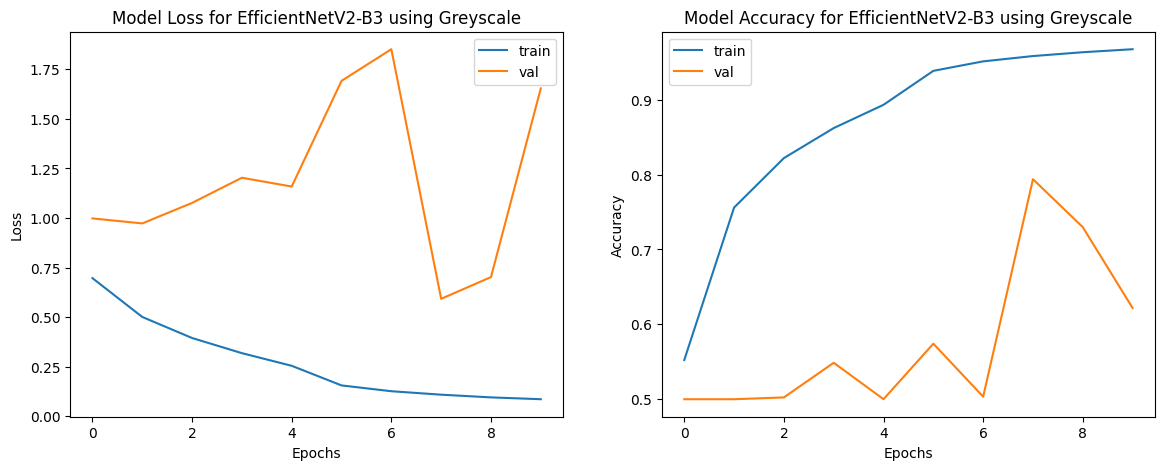

In [12]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('Model Accuracy for EfficientNetV2-B3 using Greyscale')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model Loss for EfficientNetV2-B3 using Greyscale')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [13]:
_, accu = Efficient_G_net.evaluate(grey_test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

79/79 [==============================] - 12s 154ms/step - loss: 1.6425 - accuracy: 0.6213
Final Test Acccuracy = 62.130


In [14]:
#Training using Xception using Greyscale
D_fake_net = Xception(weights=None,
                         include_top=False,
                         input_shape=(128,128,1)
                        )
def get_model():
    
    model = tf.keras.models.Sequential([D_fake_net,
                                        GlobalAveragePooling2D(),
                                        #Dense(512, activation='relu'),
                                        #BatchNormalization(),
                                        #Dropout(0.2),
                                        Dense(1, activation='sigmoid', dtype = 'float32')
                                      ])
    #following line for nvidia gpu only
    model.compile(optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.008)), loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.compile(optimizer=Adam(lr=0.008),loss='binary_crossentropy',metrics=['accuracy'])

    return model

Xception_G_net = get_model()
Xception_G_net.summary()

checkpoint = ModelCheckpoint(filepath='Xception_Grey_net.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.00008
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20860904  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,862,953
Trainable params: 20,808,425
Non-trainable params: 54,528
_________________________________________________________________


In [15]:
# timing the training process
tic2 = time.perf_counter()    # start timer

hist2 = Xception_G_net.fit(grey_training_set,
                    validation_data=grey_validation_set,
                    callbacks=callbacks,
                    epochs=10
                   )

toc2 = time.perf_counter()    # stop timer
print(f"\n[INFO] Training completed in {(toc2 - tic2)/60:0.4f} minutes\n")

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.6563
Epoch 1: val_loss improved from inf to 0.81913, saving model to Xception_Grey_net.h5
391/391 [==============================] - 80s 191ms/step - loss: 0.6350 - accuracy: 0.6563 - val_loss: 0.8191 - val_accuracy: 0.6137 - lr: 0.0080
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.4295 - accuracy: 0.8015
Epoch 2: val_loss did not improve from 0.81913
391/391 [==============================] - 73s 187ms/step - loss: 0.4295 - accuracy: 0.8015 - val_loss: 0.8384 - val_accuracy: 0.6499 - lr: 0.0080
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8740
Epoch 3: val_loss improved from 0.81913 to 0.39623, saving model to Xception_Grey_net.h5
391/391 [==============================] - 74s 189ms/step - loss: 0.2963 - accuracy: 0.8740 - val_loss: 0.3962 - val_accuracy: 0.8273 - lr: 0.0080
Epoch 4/10
391/391 [==============================

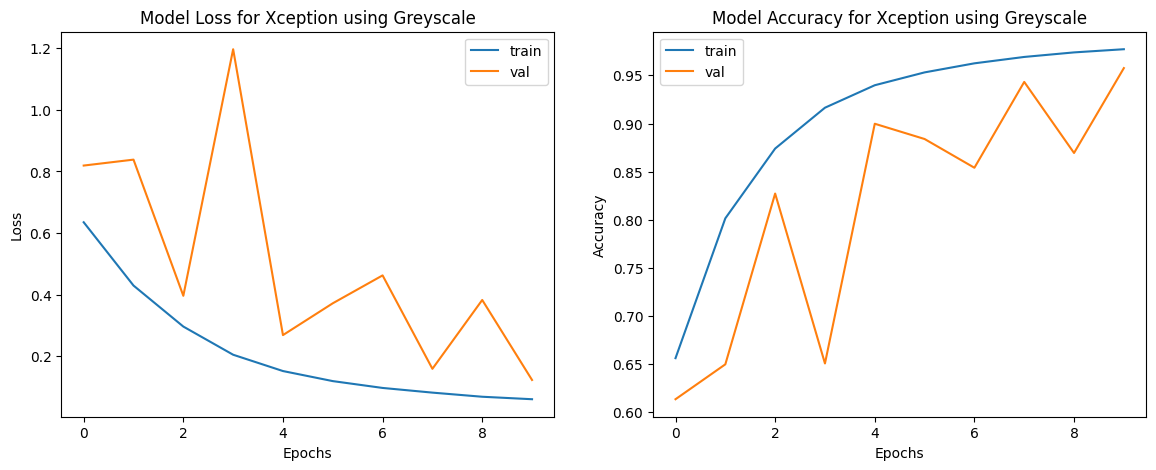

In [16]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('Model Accuracy for Xception using Greyscale')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model Loss for Xception using Greyscale')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [17]:
_, accu = Xception_G_net.evaluate(grey_test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

79/79 [==============================] - 12s 153ms/step - loss: 0.1190 - accuracy: 0.9571
Final Test Acccuracy = 95.710


In [18]:
#Training using DenseNet169 using Greyscale
D_fake_net = DenseNet169(weights=None,
                         include_top=False,
                         input_shape=(128,128,1)
                        )
def get_model():
    
    model = tf.keras.models.Sequential([D_fake_net,
                                        GlobalAveragePooling2D(),
                                        #Dense(512, activation='relu'),
                                        #BatchNormalization(),
                                        #Dropout(0.2),
                                        Dense(1, activation='sigmoid', dtype = 'float32')
                                      ])
    #following line for nvidia gpu only
    model.compile(optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.008)), loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.compile(optimizer=Adam(lr=0.008),loss='binary_crossentropy',metrics=['accuracy'])

    return model

DenseNet169_G_net = get_model()
DenseNet169_G_net.summary()

checkpoint = ModelCheckpoint(filepath='DenseNet169_Grey_net.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.00008
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 4, 4, 1664)        12636608  
                                                                 
 global_average_pooling2d_2   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 1665      
                                                                 
Total params: 12,638,273
Trainable params: 12,479,873
Non-trainable params: 158,400
_________________________________________________________________


In [19]:
# timing the training process
tic3 = time.perf_counter()    # start timer

hist3 = DenseNet169_G_net.fit(grey_training_set,
                    validation_data=grey_validation_set,
                    callbacks=callbacks,
                    epochs=10
                   )

toc3 = time.perf_counter()    # stop timer
print(f"\n[INFO] Training completed in {(toc3 - tic3)/60:0.4f} minutes\n")

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.6215
Epoch 1: val_loss improved from inf to 5.21317, saving model to DenseNet169_Grey_net.h5
391/391 [==============================] - 114s 253ms/step - loss: 0.6606 - accuracy: 0.6215 - val_loss: 5.2132 - val_accuracy: 0.5000 - lr: 0.0080
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.7559
Epoch 2: val_loss improved from 5.21317 to 1.03589, saving model to DenseNet169_Grey_net.h5
391/391 [==============================] - 97s 247ms/step - loss: 0.5002 - accuracy: 0.7559 - val_loss: 1.0359 - val_accuracy: 0.6583 - lr: 0.0080
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8072
Epoch 3: val_loss improved from 1.03589 to 0.50256, saving model to DenseNet169_Grey_net.h5
391/391 [==============================] - 97s 248ms/step - loss: 0.4210 - accuracy: 0.8072 - val_loss: 0.5026 - val_accuracy: 0.7667 - lr: 0.008

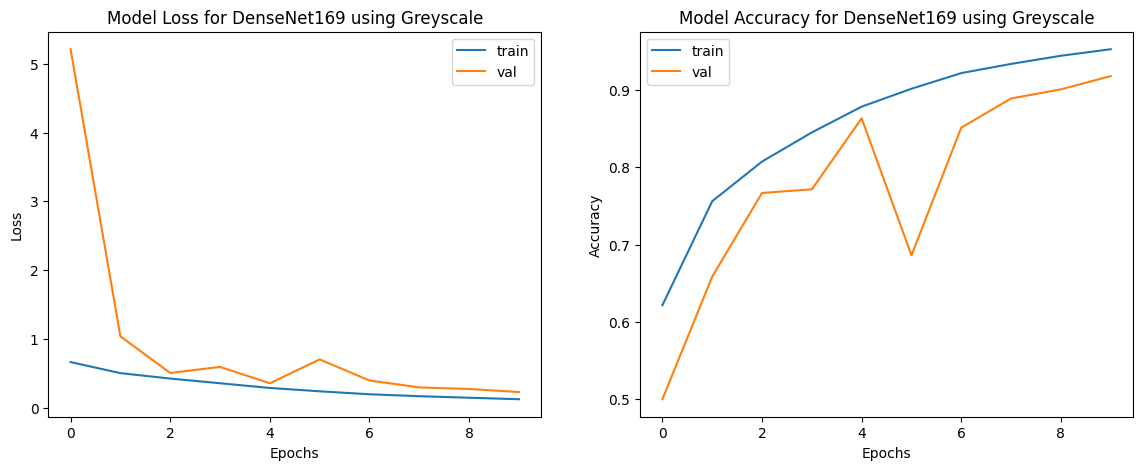

In [20]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('Model Accuracy for DenseNet169 using Greyscale')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Model Loss for DenseNet169 using Greyscale')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [21]:
_, accu = DenseNet169_G_net.evaluate(grey_test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

79/79 [==============================] - 12s 156ms/step - loss: 0.2230 - accuracy: 0.9187
Final Test Acccuracy = 91.875


In [22]:
#Training using InceptionResNetV2 using Greyscale
D_fake_net = InceptionResNetV2(weights=None,
                         include_top=False,
                         input_shape=(128,128,1)
                        )
def get_model():
    
    model = tf.keras.models.Sequential([D_fake_net,
                                        GlobalAveragePooling2D(),
                                        #Dense(512, activation='relu'),
                                        #BatchNormalization(),
                                        #Dropout(0.2),
                                        Dense(1, activation='sigmoid', dtype = 'float32')
                                      ])
    #following line for nvidia gpu only
    model.compile(optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.008)), loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.compile(optimizer=Adam(lr=0.008),loss='binary_crossentropy',metrics=['accuracy'])

    return model

InceptionResNetV2_G_net = get_model()
InceptionResNetV2_G_net.summary()

checkpoint = ModelCheckpoint(filepath='InceptionResNetV2_Grey_net.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.00008
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336160  
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 54,337,697
Trainable params: 54,277,153
Non-trainable params: 60,544
_________________________________________________________________


In [23]:
# timing the training process
tic4 = time.perf_counter()    # start timer

hist4 = InceptionResNetV2_G_net.fit(grey_training_set,
                    validation_data=grey_validation_set,
                    callbacks=callbacks,
                    epochs=10
                   )

toc4 = time.perf_counter()    # stop timer
print(f"\n[INFO] Training completed in {(toc4 - tic4)/60:0.4f} minutes\n")

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.6494
Epoch 1: val_loss improved from inf to 1.01507, saving model to InceptionResNetV2_Grey_net.h5
391/391 [==============================] - 106s 227ms/step - loss: 0.6594 - accuracy: 0.6494 - val_loss: 1.0151 - val_accuracy: 0.6188 - lr: 0.0080
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.7764
Epoch 2: val_loss improved from 1.01507 to 0.51529, saving model to InceptionResNetV2_Grey_net.h5
391/391 [==============================] - 85s 216ms/step - loss: 0.4725 - accuracy: 0.7764 - val_loss: 0.5153 - val_accuracy: 0.7703 - lr: 0.0080
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.8482
Epoch 3: val_loss improved from 0.51529 to 0.44646, saving model to InceptionResNetV2_Grey_net.h5
391/391 [==============================] - 86s 220ms/step - loss: 0.3472 - accuracy: 0.8482 - val_loss: 0.4465 - val_accuracy: 

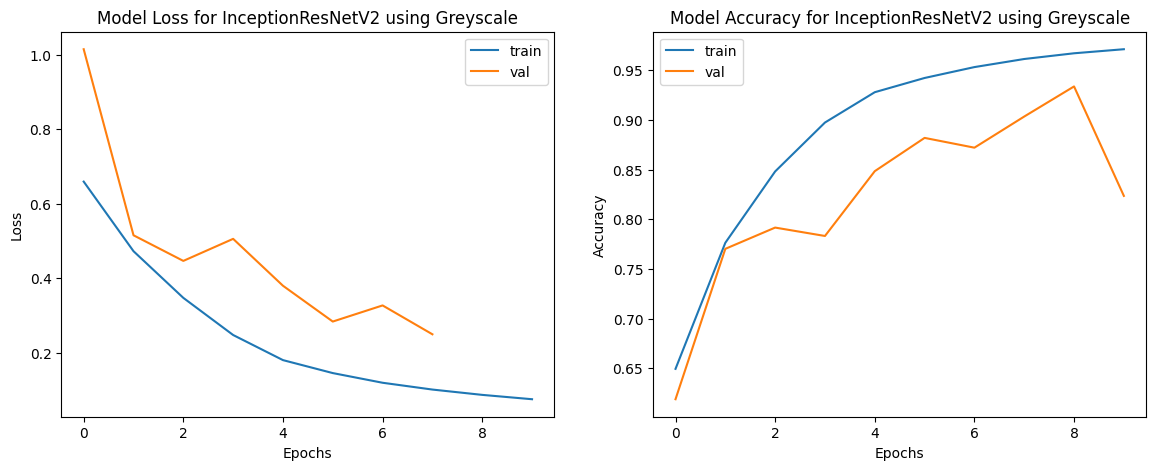

In [24]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist4.history['accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.title('Model Accuracy for InceptionResNetV2 using Greyscale')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Model Loss for InceptionResNetV2 using Greyscale')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [25]:
_, accu = InceptionResNetV2_G_net.evaluate(grey_test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

79/79 [==============================] - 12s 157ms/step - loss: 0.4405 - accuracy: 0.8253
Final Test Acccuracy = 82.535


# Colour Dataset training starts here

In [44]:
#Training using EfficientNetV2-B3 using RGB
D_fake_net = EfficientNetV2B3(weights='imagenet',
                         include_top=False,
                         input_shape=(128,128,3)
                        )
def get_model():
    
    model = tf.keras.models.Sequential([D_fake_net,
                                        GlobalAveragePooling2D(),
                                        #Dense(512, activation='relu'),
                                        #BatchNormalization(),
                                        #Dropout(0.2),
                                        Dense(1, activation='sigmoid', dtype = 'float32')
                                      ])
    #following line for nvidia gpu only
    model.compile(optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.008)), loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.compile(optimizer=Adam(lr=0.008),loss='binary_crossentropy',metrics=['accuracy'])

    return model

Efficient_RGB_net = get_model()
Efficient_RGB_net.summary()

checkpoint = ModelCheckpoint(filepath='Efficient_Colour_net.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.00008
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 4, 4, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_4   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 12,932,159
Trainable params: 12,822,943
Non-trainable params: 109,216
_________________________________________________________________


In [45]:
# timing the training process
tic6 = time.perf_counter()    # start timer

hist6 = Efficient_RGB_net.fit(RGB_training_set,
                    validation_data=RGB_validation_set,
                    callbacks=callbacks,
                    epochs=10
                   )

toc6 = time.perf_counter()    # stop timer
print(f"\n[INFO] Training completed in {(toc6 - tic6)/60:0.4f} minutes\n")

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.7620
Epoch 1: val_loss improved from inf to 0.69547, saving model to Efficient_Colour_net.h5
391/391 [==============================] - 94s 209ms/step - loss: 0.4784 - accuracy: 0.7620 - val_loss: 0.6955 - val_accuracy: 0.5000 - lr: 0.0080
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.8843
Epoch 2: val_loss did not improve from 0.69547
391/391 [==============================] - 80s 203ms/step - loss: 0.2715 - accuracy: 0.8843 - val_loss: 0.8392 - val_accuracy: 0.5005 - lr: 0.0080
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9265
Epoch 3: val_loss did not improve from 0.69547
391/391 [==============================] - 80s 204ms/step - loss: 0.1822 - accuracy: 0.9265 - val_loss: 0.7101 - val_accuracy: 0.4999 - lr: 0.0080
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 

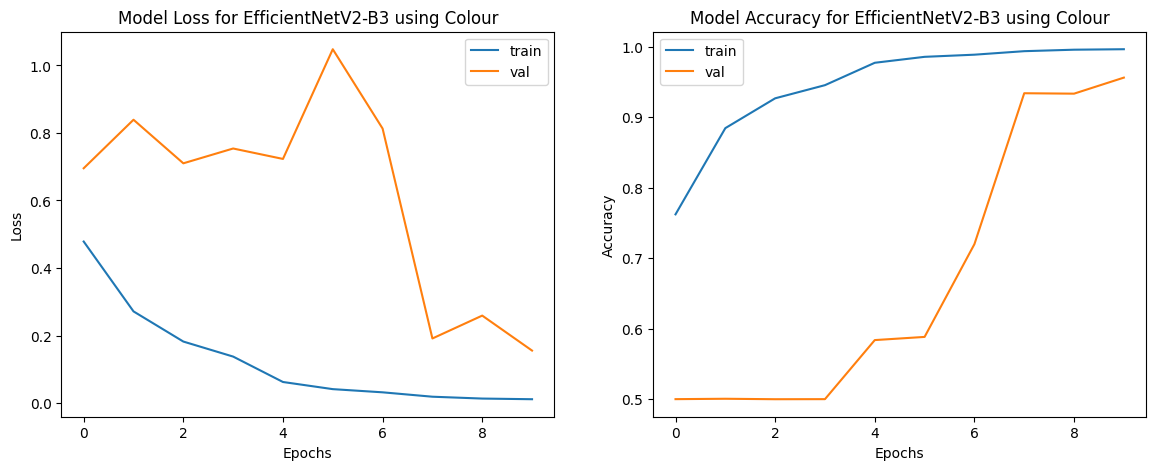

In [46]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist6.history['accuracy'])
plt.plot(hist6.history['val_accuracy'])
plt.title('Model Accuracy for EfficientNetV2-B3 using Colour')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist6.history['loss'])
plt.plot(hist6.history['val_loss'])
plt.title('Model Loss for EfficientNetV2-B3 using Colour')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [47]:
_, accu = Efficient_RGB_net.evaluate(RGB_test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

79/79 [==============================] - 20s 250ms/step - loss: 0.1538 - accuracy: 0.9582
Final Test Acccuracy = 95.820


In [48]:
#Training using Xception using RGB
D_fake_net = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(128,128,3)
                        )
def get_model():
    
    model = tf.keras.models.Sequential([D_fake_net,
                                        GlobalAveragePooling2D(),
                                        #Dense(512, activation='relu'),
                                        #BatchNormalization(),
                                        #Dropout(0.2),
                                        Dense(1, activation='sigmoid', dtype = 'float32')
                                      ])
    #following line for nvidia gpu only
    model.compile(optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.008)), loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.compile(optimizer=Adam(lr=0.008),loss='binary_crossentropy',metrics=['accuracy'])

    return model

Xception_RGB_net = get_model()
Xception_RGB_net.summary()

checkpoint = ModelCheckpoint(filepath='Xception_Colour_net.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.00008
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [49]:
# timing the training process
tic7 = time.perf_counter()    # start timer

hist7 = Xception_RGB_net.fit(RGB_training_set,
                    validation_data=RGB_validation_set,
                    callbacks=callbacks,
                    epochs=10
                   )

toc7 = time.perf_counter()    # stop timer
print(f"\n[INFO] Training completed in {(toc7 - tic7)/60:0.4f} minutes\n")

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.3415 - accuracy: 0.8251
Epoch 1: val_loss improved from inf to 0.64470, saving model to Xception_Colour_net.h5
391/391 [==============================] - 83s 201ms/step - loss: 0.3415 - accuracy: 0.8251 - val_loss: 0.6447 - val_accuracy: 0.7944 - lr: 0.0080
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.0980 - accuracy: 0.9623
Epoch 2: val_loss did not improve from 0.64470
391/391 [==============================] - 79s 201ms/step - loss: 0.0980 - accuracy: 0.9623 - val_loss: 0.8008 - val_accuracy: 0.7923 - lr: 0.0080
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9761
Epoch 3: val_loss improved from 0.64470 to 0.26583, saving model to Xception_Colour_net.h5
391/391 [==============================] - 79s 201ms/step - loss: 0.0648 - accuracy: 0.9761 - val_loss: 0.2658 - val_accuracy: 0.9178 - lr: 0.0080
Epoch 4/10
391/391 [==========================

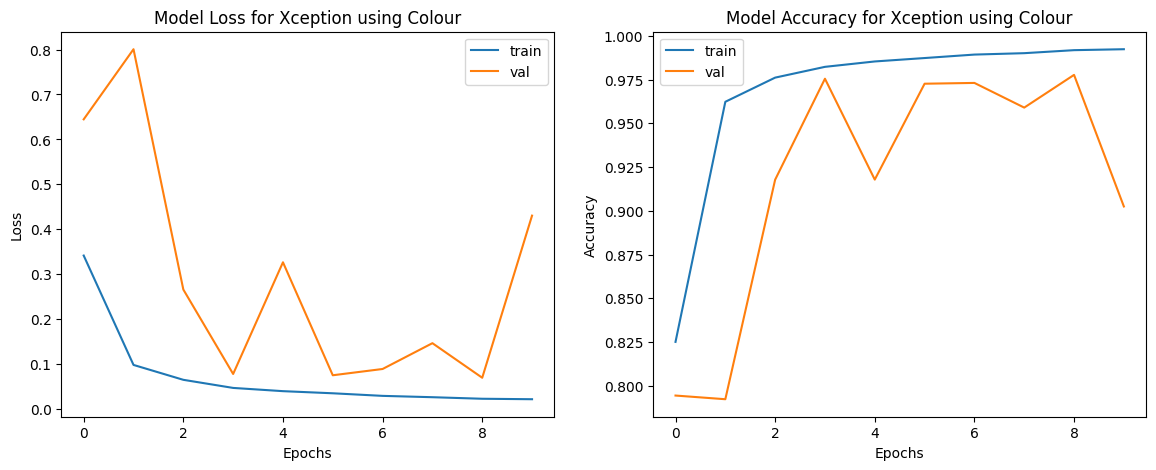

In [50]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist7.history['accuracy'])
plt.plot(hist7.history['val_accuracy'])
plt.title('Model Accuracy for Xception using Colour')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist7.history['loss'])
plt.plot(hist7.history['val_loss'])
plt.title('Model Loss for Xception using Colour')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [51]:
_, accu = Xception_RGB_net.evaluate(RGB_test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

79/79 [==============================] - 13s 162ms/step - loss: 0.4476 - accuracy: 0.9017
Final Test Acccuracy = 90.170


In [52]:
#Training using DenseNet169 using RGB
D_fake_net = DenseNet169(weights='imagenet',
                         include_top=False,
                         input_shape=(128,128,3)
                        )
def get_model():
    
    model = tf.keras.models.Sequential([D_fake_net,
                                        GlobalAveragePooling2D(),
                                        #Dense(512, activation='relu'),
                                        #BatchNormalization(),
                                        #Dropout(0.2),
                                        Dense(1, activation='sigmoid', dtype = 'float32')
                                      ])
    #following line for nvidia gpu only
    model.compile(optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.008)), loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.compile(optimizer=Adam(lr=0.008),loss='binary_crossentropy',metrics=['accuracy'])

    return model

DenseNet169_RGB_net = get_model()
DenseNet169_RGB_net.summary()

checkpoint = ModelCheckpoint(filepath='DenseNet169_Colour_net.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.00008
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

51877672/51877672 [==============================] - 5s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 4, 4, 1664)        12642880  
                                                                 
 global_average_pooling2d_6   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 12,486,145
Non-trainable params: 158,400
_________________________________________________________________


In [53]:
# timing the training process
tic8 = time.perf_counter()    # start timer

hist8 = DenseNet169_RGB_net.fit(RGB_training_set,
                    validation_data=RGB_validation_set,
                    callbacks=callbacks,
                    epochs=10
                   )

toc8 = time.perf_counter()    # stop timer
print(f"\n[INFO] Training completed in {(toc8 - tic8)/60:0.4f} minutes\n")

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6497 - accuracy: 0.6382
Epoch 1: val_loss improved from inf to 0.79943, saving model to DenseNet169_Colour_net.h5
391/391 [==============================] - 111s 246ms/step - loss: 0.6497 - accuracy: 0.6382 - val_loss: 0.7994 - val_accuracy: 0.6345 - lr: 0.0080
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.7898
Epoch 2: val_loss did not improve from 0.79943
391/391 [==============================] - 93s 238ms/step - loss: 0.4484 - accuracy: 0.7898 - val_loss: 3.2200 - val_accuracy: 0.5110 - lr: 0.0080
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.3445 - accuracy: 0.8476
Epoch 3: val_loss improved from 0.79943 to 0.59088, saving model to DenseNet169_Colour_net.h5
391/391 [==============================] - 93s 237ms/step - loss: 0.3445 - accuracy: 0.8476 - val_loss: 0.5909 - val_accuracy: 0.7546 - lr: 0.0080
Epoch 4/10
391/391 [===================

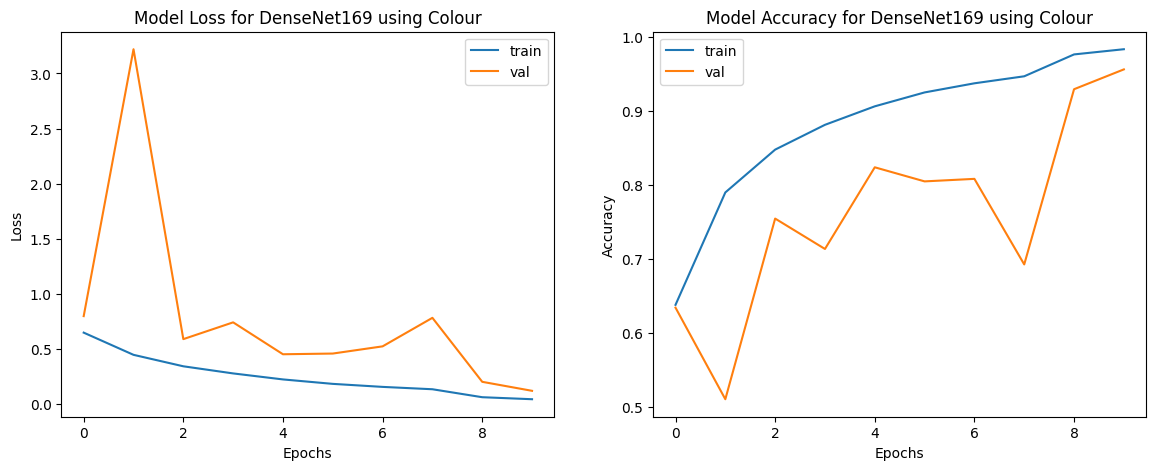

In [54]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist8.history['accuracy'])
plt.plot(hist8.history['val_accuracy'])
plt.title('Model Accuracy for DenseNet169 using Colour')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist8.history['loss'])
plt.plot(hist8.history['val_loss'])
plt.title('Model Loss for DenseNet169 using Colour')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [55]:
_, accu = DenseNet169_RGB_net.evaluate(RGB_test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

79/79 [==============================] - 12s 154ms/step - loss: 0.1219 - accuracy: 0.9561
Final Test Acccuracy = 95.610


In [70]:
#Training using InceptionResNetV2 using RGB
D_fake_net = InceptionResNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(128,128,3)
                        )
def get_model():
    
    model = tf.keras.models.Sequential([D_fake_net,
                                        GlobalAveragePooling2D(),
                                        #Dense(512, activation='relu'),
                                        #BatchNormalization(),
                                        #Dropout(0.2),
                                        Dense(1, activation='sigmoid', dtype = 'float32')
                                      ])
    #following line for nvidia gpu only
    model.compile(optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.008)), loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.compile(optimizer=Adam(lr=0.008),loss='binary_crossentropy',metrics=['accuracy'])

    return model

InceptionResNetV2_RGB_net = get_model()
InceptionResNetV2_RGB_net.summary()

checkpoint = ModelCheckpoint(filepath='InceptionResNetV2_Colour_net.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.00008
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_9   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 54,338,273
Trainable params: 54,277,729
Non-trainable params: 60,544
_________________________________________________________________


In [71]:
# timing the training process
tic9 = time.perf_counter()    # start timer

hist9 = InceptionResNetV2_RGB_net.fit(RGB_training_set,
                    validation_data=RGB_validation_set,
                    callbacks=callbacks,
                    epochs=10
                   )

toc9 = time.perf_counter()    # stop timer
print(f"\n[INFO] Training completed in {(toc9 - tic9)/60:0.4f} minutes\n")

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.5200
Epoch 1: val_loss did not improve from inf
391/391 [==============================] - 103s 221ms/step - loss: 0.7408 - accuracy: 0.5200 - val_loss: nan - val_accuracy: 0.4918 - lr: 0.0080
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.7000
Epoch 2: val_loss improved from inf to 0.63345, saving model to InceptionResNetV2_Colour_net.h5
391/391 [==============================] - 86s 218ms/step - loss: 0.5782 - accuracy: 0.7000 - val_loss: 0.6334 - val_accuracy: 0.7079 - lr: 0.0080
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8454
Epoch 3: val_loss improved from 0.63345 to 0.46127, saving model to InceptionResNetV2_Colour_net.h5
391/391 [==============================] - 86s 218ms/step - loss: 0.3518 - accuracy: 0.8454 - val_loss: 0.4613 - val_accuracy: 0.7887 - lr: 0.0080
Epoch 4/10
391/391 [==============

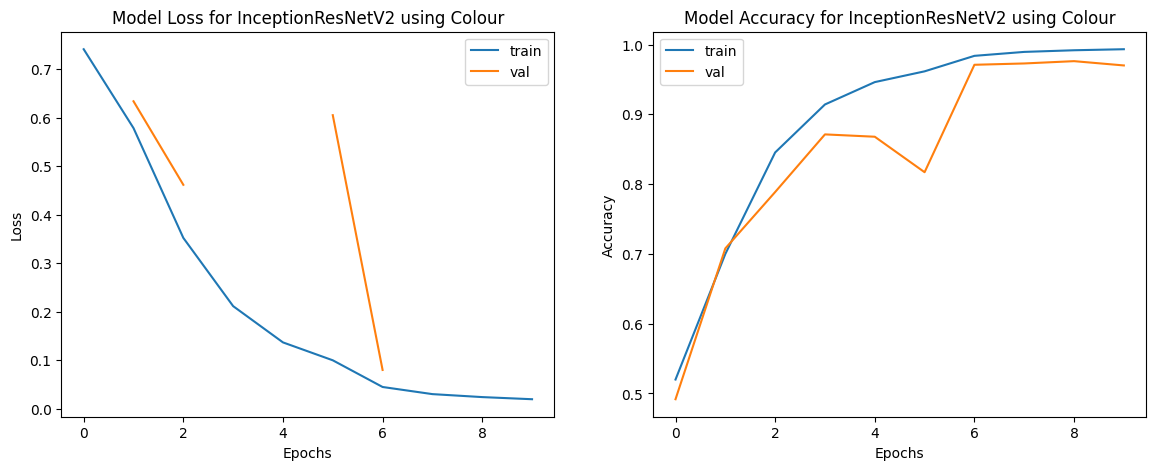

In [72]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist9.history['accuracy'])
plt.plot(hist9.history['val_accuracy'])
plt.title('Model Accuracy for InceptionResNetV2 using Colour')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist9.history['loss'])
plt.plot(hist9.history['val_loss'])
plt.title('Model Loss for InceptionResNetV2 using Colour')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [73]:
_, accu = InceptionResNetV2_RGB_net.evaluate(RGB_test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

79/79 [==============================] - 13s 163ms/step - loss: nan - accuracy: 0.9736
Final Test Acccuracy = 97.355
